In [1]:
import numpy as np
import pandas as pd
import websocket
import json
import ssl
import threading
import sys
import pickle
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

## Methods

### Reporter and Loader Methods

In [2]:
def reporter(keys, ask_prices, bid_prices, ids, ask_arbitrage_vals, bid_arbitrage_vals):
    print(f"Number of Found Arbitrages: {len(keys)}")
    key_arbitrage_counts = np.unique(np.array(keys), return_counts=True, axis = 0)
    keys_found = key_arbitrage_counts[0]
    arbitrage_counts = key_arbitrage_counts[1]
    for i in range(len(key_arbitrage_counts[0])):
        print(f"{keys_found[i]}----> {arbitrage_counts[i]}")

    for i in range(len(keys)):
        print(f"----------{i+1}---------------")
        print("Symbols:")
        print(keys[i][0], keys[i][1], keys[i][2])
        print("IDs:")
        print(ids[i][0], ids[i][1], ids[i][2])
        print("Ask Prices:")
        print(ask_prices[i][0], ask_prices[i][1], ask_prices[i][2])
        print("Ask Arbitrage Value:")
        print(ask_arbitrage_vals[i])
        print("Bid Prices:")
        print(bid_prices[i][0], bid_prices[i][1], bid_prices[i][2])
        print("Bid Arbitrage Value:")
        print(bid_arbitrage_vals[i])
        print("---------------------------")

In [3]:
def load_results(extend = False):
    loaded_keys = []
    loaded_ask_prices = []
    loaded_bid_prices = []
    loaded_ids = []
    loaded_ask_arbitrage_vals = []
    loaded_bid_arbitrage_vals = []

    open_keys = "keys"
    open_ask_prices = "ask_prices"
    open_bid_prices = "bid_prices"
    open_ids = "ids"
    open_aav = "ask_arbitrage_vals"
    open_bav = "bid_arbitrage_vals"
    if extend:
        open_keys += "2"
        open_ask_prices += "2"
        open_bid_prices += "2"
        open_ids += "2"
        open_aav += "2"
        open_bav += "2"

    with open(open_keys, "rb") as k:   
        loaded_keys = pickle.load(k) 
    
    with open(open_ask_prices, "rb") as ap:   
        loaded_ask_prices = pickle.load(ap)

    with open(open_bid_prices, "rb") as bp:   
        loaded_bid_prices = pickle.load(bp)
    
    with open(open_ids, "rb") as id:   
       loaded_ids = pickle.load(id)
    
    with open(open_aav, "rb") as aav:   
        loaded_ask_arbitrage_vals = pickle.load(aav)
    
    with open(open_bav, "rb") as bav:   
        loaded_bid_arbitrage_vals = pickle.load(bav)

    return loaded_keys, loaded_ask_prices, loaded_bid_prices, loaded_ids, loaded_ask_arbitrage_vals, loaded_bid_arbitrage_vals

### Plotting Methods

In [4]:
def triangular_arbitrage_plotter():
    # Observed triangular arbitrages
    data = {
        ('BCHBTC', 'BTCUSDT', 'BCHUSDT'): 13,
        ('BTCEUR', 'EURUSDT', 'BTCUSDT'): 202,
        ('EOSBTC', 'BTCUSDT', 'EOSUSDT'): 202,
        ('ETHEUR', 'EURUSDT', 'ETHUSDT'): 693,
        ('ETHBTC', 'BTCEUR', 'ETHEUR'): 125,
        ('LTCBTC', 'BTCUSDT', 'LTCUSDT'): 202
    }

    # Extracting labels and counts
    labels = [str(key) for key in data.keys()]
    counts = list(data.values())

    # Plot
    plt.figure(figsize=(12, 7))
    bars = plt.barh(labels, counts, color='skyblue')
    plt.xlabel('Frequency', fontsize=15, weight='bold')
    plt.ylabel('Symbol Pairs', fontsize=15, weight='bold')
    plt.title('Count of Arbitrage Opportunities per Trading Pairs', fontsize=16, weight='bold', color='black')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top

    # Adding annotations
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', 
                va='center', ha='left', fontsize=12, weight='bold', color='black')

    # Set axis labels to bold
    plt.xticks(weight='bold', fontsize = 12)
    plt.yticks(weight='bold', fontsize = 12)
    plt.show()

In [5]:
def arbitrage_trigger_detecter_plot(loaded_ask_arbitrage_vals, loaded_ask_arbitrage_vals2, loaded_bid_arbitrage_vals, loaded_bid_arbitrage_vals2):
    ask_arbs = np.array(loaded_ask_arbitrage_vals + loaded_ask_arbitrage_vals2)
    bid_arbs = np.array(loaded_bid_arbitrage_vals + loaded_bid_arbitrage_vals2)
    common = 0
    ask = 0
    bid = 0
    for i in range(len(ask_arbs)):
        if ask_arbs[i] < 1 and bid_arbs[i] > 1:
            common += 1
        elif ask_arbs[i] < 1:
            ask += 1
        elif bid_arbs[i] > 1:
            bid += 1

    # Create the Venn diagram
    # Set font size
    plt.rcParams.update({'font.size': 17, 'text.color': 'white'})
    venn = venn2(subsets=(bid, ask, common), 
                set_labels=('Bid Price', 'Ask Price', 'Both'))
    
    # Set colors
    venn.get_patch_by_id('10').set_color('red')  # solely bid
    venn.get_patch_by_id('01').set_color('blue')  # solely ask
    venn.get_patch_by_id('11').set_color('purple')  # common

    # Set plot size
    plt.gcf().set_size_inches(10, 7)

    # Show the plot
    plt.title("Venn Diagram of Arbitrage Triggers")
    plt.show()
    



In [41]:
def ask_bid_price_comparetor(loaded_keys, loaded_keys2, loaded_ask_prices, loaded_ask_prices2, loaded_bid_prices, loaded_bid_prices2):
    #Common: ['BCHBTC' 'BTCUSDT' 'BCHUSDT'], ['EOSBTC' 'BTCUSDT' 'EOSUSDT']
    #loaded_keys2: ['BTCEUR' 'EURUSDT' 'BTCUSDT'], ['ETHEUR' 'EURUSDT' 'ETHUSDT']
    #loaded_keys: ['ETHBTC' 'BTCEUR' 'ETHEUR'], ['LTCBTC' 'BTCUSDT' 'LTCUSDT']
    loaded_keys_arr = np.array(loaded_keys)  
    loaded_keys_arr2 = np.array(loaded_keys2)    
    loaded_ask_prices_arr = np.array(loaded_ask_prices)
    loaded_ask_prices_arr2 = np.array(loaded_ask_prices2)
    loaded_bid_prices_arr = np.array(loaded_bid_prices)
    loaded_bid_prices_arr2 = np.array(loaded_bid_prices2)
    #Index finder                                           
    lk_indices = np.where(np.all(loaded_keys_arr == np.array(['ETHBTC', 'BTCEUR' ,'ETHEUR']), axis=1))[0]
    lk_indices2 = np.where(np.all(loaded_keys_arr == np.array(['LTCBTC', 'BTCUSDT', 'LTCUSDT']), axis=1))[0]
    lk_indices3 = np.where(np.all(loaded_keys_arr == np.array(['BCHBTC', 'BTCUSDT', 'BCHUSDT']), axis=1))[0]
    lk_indices4 = np.where(np.all(loaded_keys_arr == np.array(['EOSBTC', 'BTCUSDT', 'EOSUSDT']), axis=1))[0]

    lk2_indices = np.where(np.all(loaded_keys_arr2 == np.array(['BTCEUR', 'EURUSDT', 'BTCUSDT']), axis=1))[0]
    lk2_indices2 = np.where(np.all(loaded_keys_arr2 == np.array(['ETHEUR', 'EURUSDT', 'ETHUSDT']), axis=1))[0]
    lk2_indices3 = np.where(np.all(loaded_keys_arr2 == np.array(['BCHBTC', 'BTCUSDT', 'BCHUSDT']), axis=1))[0]
    lk2_indices4 = np.where(np.all(loaded_keys_arr2 == np.array(['EOSBTC', 'BTCUSDT', 'EOSUSDT']), axis=1))[0]

    #ETHBTC
    print("ETHBTC")
    ethbtc_ask = np.average(loaded_ask_prices_arr[lk_indices,0])
    ethbtc_bid = np.average(loaded_bid_prices_arr[lk_indices,0])
    print(ethbtc_ask, ethbtc_bid, ethbtc_ask - ethbtc_bid)
    #BTCEUR
    print("BTCEUR")
    btceur_ask = np.average(list(loaded_ask_prices_arr[lk_indices,1]) + list(loaded_ask_prices_arr2[lk2_indices,0]))
    btceur_bid = np.average(list(loaded_bid_prices_arr[lk_indices,1]) + list(loaded_bid_prices_arr2[lk2_indices,0]))
    print(btceur_ask, btceur_bid, btceur_ask - btceur_bid)
    #ETHEUR
    print("ETHEUR")
    etheur_ask = np.average(list(loaded_ask_prices_arr[lk_indices,2]) + list(loaded_ask_prices_arr2[lk2_indices2,0]))
    etheur_bid = np.average(list(loaded_bid_prices_arr[lk_indices,2]) + list(loaded_bid_prices_arr2[lk2_indices2,0]))
    print(etheur_ask, etheur_bid, etheur_ask - etheur_bid)
    #LTCBTC
    print("LTCBTC")
    ltcbtc_ask = np.average(loaded_ask_prices_arr[lk_indices2,0])
    ltcbtc_bid = np.average(loaded_bid_prices_arr[lk_indices2,0])
    print(ltcbtc_ask, ltcbtc_bid, ltcbtc_ask - ltcbtc_bid)
    #BTCUSDT
    print("BTCUSDT")
    btcusdt_ask = np.average(list(loaded_ask_prices_arr[lk_indices2,1]) + list(loaded_ask_prices_arr[lk_indices3,1]) + list(loaded_ask_prices_arr[lk_indices4,1]) + \
                  list(loaded_ask_prices_arr2[lk2_indices,2]) + list(loaded_ask_prices_arr2[lk2_indices3,1]) + list(loaded_ask_prices_arr2[lk2_indices4,1]))
    
    btcusdt_bid = np.average(list(loaded_bid_prices_arr[lk_indices2,1]) + list(loaded_bid_prices_arr[lk_indices3,1]) + list(loaded_bid_prices_arr[lk_indices4,1]) + \
                  list(loaded_bid_prices_arr2[lk2_indices,2]) + list(loaded_bid_prices_arr2[lk2_indices3,1]) + list(loaded_bid_prices_arr2[lk2_indices4,1]))
    
    print(btcusdt_ask, btcusdt_bid, btcusdt_ask - btcusdt_bid)
    #LTCUSDT
    print("LTCUSDT")
    ltcusdt_ask = np.average(loaded_ask_prices_arr[lk_indices2,2])
    ltcusdt_bid = np.average(loaded_bid_prices_arr[lk_indices2,2])
    print(ltcusdt_ask, ltcusdt_bid, ltcusdt_ask - ltcusdt_bid)
    #BCHBTC
    print("BCHBTC")
    bchbtc_ask = np.average(list(loaded_ask_prices_arr[lk_indices3,0]) + list(loaded_ask_prices_arr2[lk2_indices3,0]))
    bchbtc_bid = np.average(list(loaded_bid_prices_arr[lk_indices3,0]) + list(loaded_bid_prices_arr2[lk2_indices3,0]))
    print(bchbtc_ask, bchbtc_bid, bchbtc_ask - bchbtc_bid)
    #BCHUSDT
    print("BCHUSDT")
    bchusdt_ask = np.average(list(loaded_ask_prices_arr[lk_indices3,2]) + list(loaded_ask_prices_arr2[lk2_indices3,2]))
    bchusdt_bid = np.average(list(loaded_bid_prices_arr[lk_indices3,2]) + list(loaded_bid_prices_arr2[lk2_indices3,2]))
    print(bchusdt_ask, bchusdt_bid, bchusdt_ask - bchusdt_bid)
    #EOSBTC
    print("EOSBTC")
    eosbtc_ask = np.average(list(loaded_ask_prices_arr[lk_indices4,0]) + list(loaded_ask_prices_arr2[lk2_indices4,0]))
    eosbtc_bid = np.average(list(loaded_bid_prices_arr[lk_indices4,0]) + list(loaded_bid_prices_arr2[lk2_indices4,0]))
    print(eosbtc_ask, eosbtc_bid, eosbtc_ask - eosbtc_bid)
    #EOSUSDT
    print("EOSUSDT")
    eosusdt_ask = np.average(list(loaded_ask_prices_arr[lk_indices4,2]) + list(loaded_ask_prices_arr2[lk2_indices4,2]))
    eosusdt_bid = np.average(list(loaded_bid_prices_arr[lk_indices4,2]) + list(loaded_bid_prices_arr2[lk2_indices4,2]))
    print(eosusdt_ask, eosusdt_bid, eosusdt_ask - eosusdt_bid)
    #EURUSDT
    print("EURUSDT")
    eurusdt_ask = np.average(list(loaded_ask_prices_arr2[lk2_indices,1]) + list(loaded_ask_prices_arr2[lk2_indices2,1]))
    eurusdt_bid = np.average(list(loaded_bid_prices_arr2[lk2_indices,1]) + list(loaded_bid_prices_arr2[lk2_indices2,1]))
    print(eurusdt_ask, eurusdt_bid, eurusdt_ask - eurusdt_bid)
    #ETHUSDT 
    print("ETHUSDT")
    ethusdt_ask = np.average(loaded_ask_prices_arr2[lk2_indices2,2])
    ethusdt_bid = np.average(loaded_bid_prices_arr2[lk2_indices2,2])
    print(ethusdt_ask, ethusdt_bid, ethusdt_ask - ethusdt_bid)



    

### Method Calls

In [7]:
loaded_keys, loaded_ask_prices, loaded_bid_prices, loaded_ids, loaded_ask_arbitrage_vals, loaded_bid_arbitrage_vals = load_results()

In [8]:
loaded_keys2, loaded_ask_prices2, loaded_bid_prices2, loaded_ids2, loaded_ask_arbitrage_vals2, loaded_bid_arbitrage_vals2 = load_results(extend = True)

In [43]:
reporter(loaded_keys2, loaded_ask_prices2, loaded_bid_prices2, loaded_ids2, loaded_ask_arbitrage_vals2, loaded_bid_arbitrage_vals2)

Number of Found Arbitrages: 900
['BCHBTC' 'BTCUSDT' 'BCHUSDT']----> 1
['BTCEUR' 'EURUSDT' 'BTCUSDT']----> 202
['EOSBTC' 'BTCUSDT' 'EOSUSDT']----> 4
['ETHEUR' 'EURUSDT' 'ETHUSDT']----> 693
----------1---------------
Symbols:
ETHEUR EURUSDT ETHUSDT
IDs:
5011178747 491096304 29735164675
Ask Prices:
2582.62 1.0765 2780.36
Ask Arbitrage Value:
0.9999390114949144
Bid Prices:
2582.41 1.0764 2780.35
Bid Arbitrage Value:
0.9997684190839282
---------------------------
----------2---------------
Symbols:
ETHEUR EURUSDT ETHUSDT
IDs:
5011178747 491096304 29735164675
Ask Prices:
2582.62 1.0765 2780.36
Ask Arbitrage Value:
0.9999390114949144
Bid Prices:
2582.41 1.0764 2780.35
Bid Arbitrage Value:
0.9997684190839282
---------------------------
----------3---------------
Symbols:
ETHEUR EURUSDT ETHUSDT
IDs:
5011178747 491096304 29735164675
Ask Prices:
2582.62 1.0765 2780.36
Ask Arbitrage Value:
0.9999390114949144
Bid Prices:
2582.41 1.0764 2780.35
Bid Arbitrage Value:
0.9997684190839282
---------------

In [ ]:
reporter(loaded_keys, loaded_ask_prices, loaded_bid_prices, loaded_ids, loaded_ask_arbitrage_vals, loaded_bid_arbitrage_vals)

#### Analysis Calls

In [42]:
ask_bid_price_comparetor(loaded_keys, loaded_keys2, loaded_ask_prices, loaded_ask_prices2, loaded_bid_prices, loaded_bid_prices2)

ETHBTC
0.053720000000000004 0.053709999999999994 1.0000000000010001e-05
BTCEUR
48037.964006116206 48037.94351681956 0.020489296643063426
ETHEUR
2582.019572127139 2581.7842053789736 0.23536674816523373
LTCBTC
0.001355 0.0013539999999999995 1.0000000000005664e-06
BTCUSDT
51699.72428109854 51699.25274636511 0.4715347334276885
LTCUSDT
69.99 69.98 0.009999999999990905
BCHBTC
0.0051885384615384614 0.005186461538461537 2.0769230769240865e-06
BCHUSDT
268.27692307692314 268.0846153846154 0.19230769230773603
EOSBTC
1.4669603960396033e-05 1.4659603960396041e-05 9.999999999991434e-09
EOSUSDT
0.7582475247524753 0.7570198019801978 0.0012277227722774509
EURUSDT
1.0764999999999998 1.0763999999999998 9.999999999998899e-05
ETHUSDT
2780.287878787879 2780.275555555555 0.012323232323979028


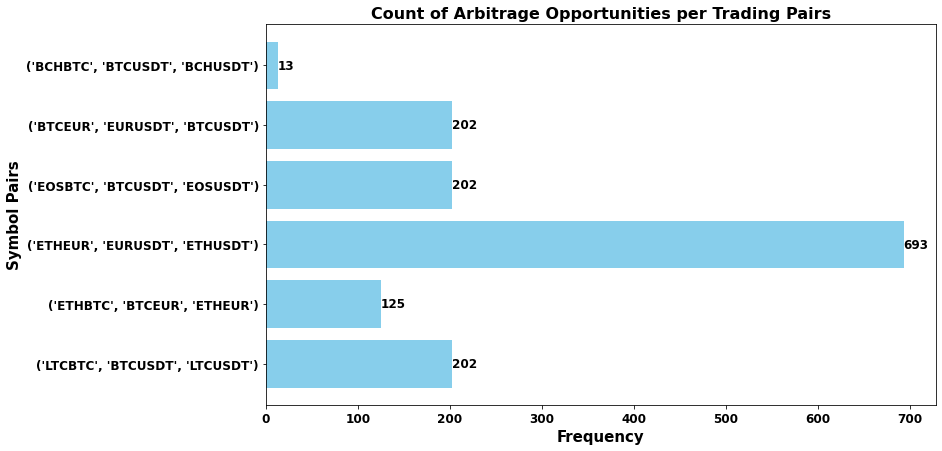

In [84]:
triangular_arbitrage_plotter()

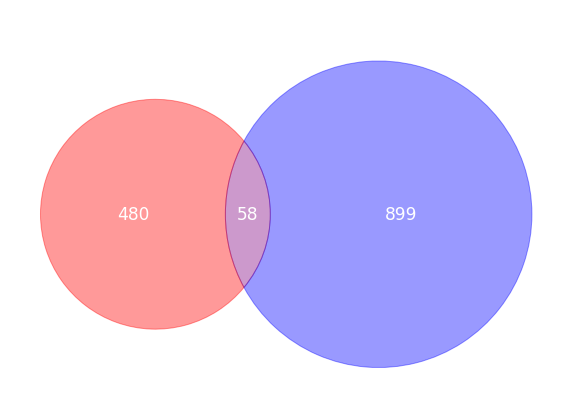

In [85]:
arbitrage_trigger_detecter_plot(loaded_ask_arbitrage_vals, loaded_ask_arbitrage_vals2, loaded_bid_arbitrage_vals, loaded_bid_arbitrage_vals2)